# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844


In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
 # change to your folder directory
%cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


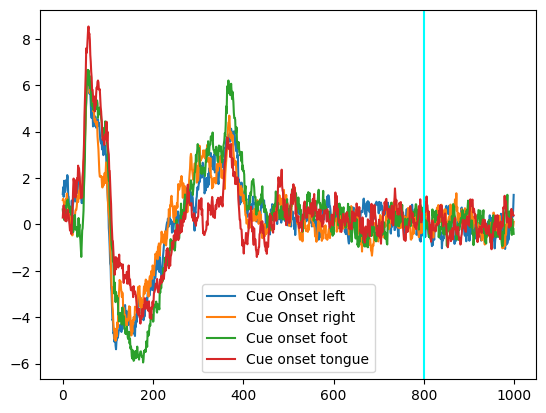

In [ ]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [ ]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))


    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y




def val_test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug

    return total_X


In [ ]:
def data_loader(X_train_valid, y_train_valid, model_choice="LSTM"):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data)

    if model_choice == "CNN":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)     # CNN; add extra dim for 2D conv

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label,2,2,True)

    if model_choice == "CNN":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)     # CNN; add extra dim for 2D conv

    # print("My training data: ", train_data_aug.shape)
    # print("My training label: ", train_label_aug.shape)
    # print()
    # print("My val data: ", val_data_aug.shape)
    # print("My val label: ", val_label.shape)
    # print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data

    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [ ]:
x_train_LSTM, y_train_LSTM, x_valid_LSTM, y_valid_LSTM = data_loader(X_train_valid, y_train_valid, model_choice="LSTM")
x_train_CNN, y_train_CNN, x_valid_CNN, y_valid_CNN= data_loader(X_train_valid, y_train_valid, model_choice="CNN")

In [ ]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(training_acc, validation_acc, name="fig"):
    x_axis = np.arange(0, len(training_acc))
    plt.plot(x_axis, training_acc, color='r', label='training')
    plt.plot(x_axis, validation_acc, color='g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [ ]:
###################################################################################
## Training Function ##############################################################
###################################################################################
def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    np.random.seed(247)
    torch.manual_seed(147)
    random.seed(0)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []


    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)


In [ ]:
###################################################################################
## Testing Function ##############################################################
###################################################################################
def test_model(model, model_choice="LSTM", X_test=X_test, y_test=y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test)

    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "CNN" or model_choice == "CLSTM":
            x_test = x_test.unsqueeze(-1)


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", model_choice, "is: ", test_acc)



# **MODEL DEFINITION**





> Here, we define the models used in this first experiment. Our models are:
1.   LSTM
2.   CNN
3.   CNN + LSTM


In [ ]:
###################################################################################
## Classification with a LSTM #####################################################
###################################################################################
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, seq_len, num_classes):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size, batch_first=True, dropout = 0.75)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.input_size = input_size
        self.seq_len = seq_len

    def forward(self, input):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        batch = input.shape[0]
        hidden = torch.zeros(self.num_layers, batch, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch, self.hidden_size).to(device)

        input = input.view(batch, self.seq_len, self.input_size)
        out, hidden = self.rnn(input, (hidden, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size, hidden_size = 22, 128
num_layers, batch_size = 3, 64
seq_len, num_classes = 400, 4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lstm = LSTM(input_size, hidden_size, num_layers, batch_size, seq_len, num_classes).to(device)
summary(lstm, input_size=x_train_LSTM[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [64, 4]                   --
├─LSTM: 1-1                              [64, 400, 128]            342,016
├─Linear: 1-2                            [64, 4]                   516
Total params: 342,532
Trainable params: 342,532
Non-trainable params: 0
Total mult-adds (G): 8.76
Input size (MB): 2.25
Forward/backward pass size (MB): 26.22
Params size (MB): 1.37
Estimated Total Size (MB): 29.84

In [ ]:
###################################################################################
## Classification with a CNN #####################################################
###################################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Block 1
        layers=[]
        layers.append(nn.Conv2d(in_channels=22, out_channels=25, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), padding=(1,0), stride=(3,1)))
        layers.append(nn.BatchNorm2d(25))
        layers.append(nn.Dropout(p=0.6))

        # Block 2
        layers.append(nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), padding=(1,0), stride=(3,1)))
        layers.append(nn.BatchNorm2d(50))
        layers.append(nn.Dropout(p=0.6))


        # Block 3
        layers.append(nn.Conv2d(in_channels=50, out_channels=100, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        layers.append(nn.BatchNorm2d(100))
        layers.append(nn.Dropout(p=0.6))


        # Block 3
        layers.append(nn.Conv2d(in_channels=100, out_channels=200, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        layers.append(nn.BatchNorm2d(200))
        layers.append(nn.Dropout(p=0.6))

        # FC Layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(1000,40))
        layers.append(nn.Linear(40,10))
        layers.append(nn.Linear(10,4))
        self.model_nn = nn.ModuleList(layers)


    def forward(self, x):

        for layer in self.model_nn:
            x = layer(x)

        return x


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)
summary(cnn, input_size=x_train_CNN[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 25, 400, 1]          13,775
│    └─ELU: 2-2                          [64, 25, 400, 1]          --
│    └─MaxPool2d: 2-3                    [64, 25, 134, 1]          --
│    └─BatchNorm2d: 2-4                  [64, 25, 134, 1]          50
│    └─Dropout: 2-5                      [64, 25, 134, 1]          --
│    └─Conv2d: 2-6                       [64, 50, 134, 1]          31,300
│    └─ELU: 2-7                          [64, 50, 134, 1]          --
│    └─MaxPool2d: 2-8                    [64, 50, 45, 1]           --
│    └─BatchNorm2d: 2-9                  [64, 50, 45, 1]           100
│    └─Dropout: 2-10                     [64, 50, 45, 1]           --
│    └─Conv2d: 2-11                      [64, 100, 45, 1]          125,100
│

In [ ]:
##################################################################################
## Classification with a CNN+LSTM ################################################
##################################################################################

class CLSTM(nn.Module):
    def __init__(self):
        super(CLSTM, self).__init__()

        layers=[]

        ###adjust params
        out_channels1 = 25
        kernel_size1 = 5
        stride1 = 1
        pool_size1 = (3,1)
        pool_padding1 = (1,0)
        p1 = 0.6
        ###
        layers.append(nn.Conv2d(in_channels=22, out_channels=out_channels1, kernel_size=kernel_size1, stride=stride1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=pool_size1, padding=pool_padding1, stride=pool_size1))
        layers.append(nn.BatchNorm2d(out_channels1))
        layers.append(nn.Dropout(p=p1))

        ###
        out_channels2 = 50
        kernel_size2 = 5
        stride2 = 1
        pool_size2 = (3,1)
        pool_padding2 = (1,0)
        p2 = 0.6
        ###

        layers.append(nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel_size2, stride=stride2, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=pool_size2, padding=pool_padding2, stride=pool_size2))
        layers.append(nn.BatchNorm2d(out_channels2))
        layers.append(nn.Dropout(p=p2))

        ###
        out_channels3 = 100
        kernel_size3 = 5
        stride3 = 1
        pool_size3 = (3,1)
        #pool_padding2 = (1,0)
        p3 = 0.6
        ###

        layers.append(nn.Conv2d(in_channels=out_channels2, out_channels=out_channels3, kernel_size=kernel_size3, stride=stride3, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=pool_size3, stride=pool_size3))
        layers.append(nn.BatchNorm2d(out_channels3))
        layers.append(nn.Dropout(p=p3))

        ###
        out_channels4 = 200
        kernel_size4 = 5
        stride4 = 1
        pool_size4 = (3,1)
        #pool_padding2 = (1,0)
        p4 = 0.6
        ###
        layers.append(nn.Conv2d(in_channels=out_channels3, out_channels=out_channels4, kernel_size=kernel_size4, stride=stride4, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=pool_size4, stride=pool_size4))
        layers.append(nn.BatchNorm2d(out_channels4))
        layers.append(nn.Dropout(p=p4))

        lstm_inputsize = 40
        lstm_hiddensize = 300
        lstm_layers = 2
        lstm_dropout = 0.4

        layers.append(nn.Flatten())
        layers.append(nn.Linear(1000,lstm_inputsize))
        layers.append(nn.LSTM(input_size=lstm_inputsize, hidden_size=lstm_hiddensize, num_layers=lstm_layers, dropout=lstm_dropout))

        layers.append(nn.Linear(lstm_hiddensize,4))
        self.model = nn.ModuleList(layers)


    def forward(self, x):
        for layer in self.model:
            #   LSTM
            if type(x) == tuple:
                x = x[0]
            x = layer(x)
        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn_lstm = CLSTM().to(device)
summary(cnn_lstm, input_size=x_train_CNN[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
CLSTM                                    [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 25, 400, 1]          13,775
│    └─ELU: 2-2                          [64, 25, 400, 1]          --
│    └─MaxPool2d: 2-3                    [64, 25, 134, 1]          --
│    └─BatchNorm2d: 2-4                  [64, 25, 134, 1]          50
│    └─Dropout: 2-5                      [64, 25, 134, 1]          --
│    └─Conv2d: 2-6                       [64, 50, 134, 1]          31,300
│    └─ELU: 2-7                          [64, 50, 134, 1]          --
│    └─MaxPool2d: 2-8                    [64, 50, 45, 1]           --
│    └─BatchNorm2d: 2-9                  [64, 50, 45, 1]           100
│    └─Dropout: 2-10                     [64, 50, 45, 1]           --
│    └─Conv2d: 2-11                      [64, 100, 45, 1]          125,100
│

# **Training Our Models**

In [ ]:
###################################################################################
## Training and Test The LSTM ##############################################################
###################################################################################
lstm = LSTM(input_size, hidden_size, num_layers, batch_size, seq_len, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 60, 64
data = {
    "x_train": x_train_LSTM,
    "y_train": y_train_LSTM,
    "x_valid": x_valid_LSTM,
    "y_valid": y_valid_LSTM
}
training_acc_LSTM, validation_acc_LSTM = train_model(data, optimizer, criterion, lstm, batch_size, num_epoch)
start_time = time.time()
test_model(lstm, model_choice="LSTM", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  LSTM(
  (rnn): LSTM(22, 128, num_layers=3, batch_first=True, dropout=0.75)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.384
[1, 52] loss: 1.386
[1, 78] loss: 1.385


  2%|▏         | 1/60 [00:03<03:06,  3.17s/it]

[1, 104] loss: 1.384
Validation Accuracy: 0.2529550790786743
Epoch:  2
[2, 26] loss: 1.381
[2, 52] loss: 1.379
[2, 78] loss: 1.372


  3%|▎         | 2/60 [00:06<02:56,  3.05s/it]

[2, 104] loss: 1.369
Validation Accuracy: 0.2434988170862198
Epoch:  3
[3, 26] loss: 1.354
[3, 52] loss: 1.356
[3, 78] loss: 1.347


  5%|▌         | 3/60 [00:09<02:52,  3.02s/it]

[3, 104] loss: 1.337
Validation Accuracy: 0.25531914830207825
Epoch:  4
[4, 26] loss: 1.309
[4, 52] loss: 1.312
[4, 78] loss: 1.308


  7%|▋         | 4/60 [00:12<02:48,  3.01s/it]

[4, 104] loss: 1.284
Validation Accuracy: 0.22695034742355347
Epoch:  5
[5, 26] loss: 1.233
[5, 52] loss: 1.228
[5, 78] loss: 1.187


  8%|▊         | 5/60 [00:15<02:45,  3.00s/it]

[5, 104] loss: 1.220
Validation Accuracy: 0.23167848587036133
Epoch:  6
[6, 26] loss: 1.134
[6, 52] loss: 1.132
[6, 78] loss: 1.118


 10%|█         | 6/60 [00:18<02:42,  3.00s/it]

[6, 104] loss: 1.124
Validation Accuracy: 0.2434988170862198
Epoch:  7
[7, 26] loss: 1.042
[7, 52] loss: 1.025
[7, 78] loss: 0.995


 12%|█▏        | 7/60 [00:21<02:39,  3.01s/it]

[7, 104] loss: 1.019
Validation Accuracy: 0.21985815465450287
Epoch:  8
[8, 26] loss: 0.939
[8, 52] loss: 0.926
[8, 78] loss: 0.954


 13%|█▎        | 8/60 [00:24<02:37,  3.03s/it]

[8, 104] loss: 0.922
Validation Accuracy: 0.2364066243171692
Epoch:  9
[9, 26] loss: 0.801
[9, 52] loss: 0.812
[9, 78] loss: 0.816


 15%|█▌        | 9/60 [00:27<02:34,  3.03s/it]

[9, 104] loss: 0.823
Validation Accuracy: 0.2364066243171692
Epoch:  10
[10, 26] loss: 0.709
[10, 52] loss: 0.660
[10, 78] loss: 0.686


 17%|█▋        | 10/60 [00:30<02:31,  3.04s/it]

[10, 104] loss: 0.695
Validation Accuracy: 0.21749408543109894
Epoch:  11
[11, 26] loss: 0.647
[11, 52] loss: 0.606
[11, 78] loss: 0.643


 18%|█▊        | 11/60 [00:33<02:28,  3.04s/it]

[11, 104] loss: 0.605
Validation Accuracy: 0.23877067863941193
Epoch:  12
[12, 26] loss: 0.536
[12, 52] loss: 0.532
[12, 78] loss: 0.527


 20%|██        | 12/60 [00:36<02:26,  3.06s/it]

[12, 104] loss: 0.545
Validation Accuracy: 0.23404255509376526
Epoch:  13
[13, 26] loss: 0.455
[13, 52] loss: 0.515
[13, 78] loss: 0.512


 22%|██▏       | 13/60 [00:39<02:23,  3.06s/it]

[13, 104] loss: 0.466
Validation Accuracy: 0.24822695553302765
Epoch:  14
[14, 26] loss: 0.386
[14, 52] loss: 0.382
[14, 78] loss: 0.420


 23%|██▎       | 14/60 [00:42<02:20,  3.06s/it]

[14, 104] loss: 0.407
Validation Accuracy: 0.24113474786281586
Epoch:  15
[15, 26] loss: 0.329
[15, 52] loss: 0.376
[15, 78] loss: 0.355


 25%|██▌       | 15/60 [00:45<02:17,  3.06s/it]

[15, 104] loss: 0.375
Validation Accuracy: 0.24113474786281586
Epoch:  16
[16, 26] loss: 0.310
[16, 52] loss: 0.320
[16, 78] loss: 0.356


 27%|██▋       | 16/60 [00:48<02:15,  3.08s/it]

[16, 104] loss: 0.363
Validation Accuracy: 0.20330969989299774
Epoch:  17
[17, 26] loss: 0.290
[17, 52] loss: 0.300
[17, 78] loss: 0.327


 28%|██▊       | 17/60 [00:51<02:12,  3.08s/it]

[17, 104] loss: 0.312
Validation Accuracy: 0.23167848587036133
Epoch:  18
[18, 26] loss: 0.261
[18, 52] loss: 0.244
[18, 78] loss: 0.261


 30%|███       | 18/60 [00:54<02:09,  3.09s/it]

[18, 104] loss: 0.281
Validation Accuracy: 0.23167848587036133
Epoch:  19
[19, 26] loss: 0.208
[19, 52] loss: 0.227
[19, 78] loss: 0.274


 32%|███▏      | 19/60 [00:57<02:06,  3.08s/it]

[19, 104] loss: 0.237
Validation Accuracy: 0.22695034742355347
Epoch:  20
[20, 26] loss: 0.193
[20, 52] loss: 0.216
[20, 78] loss: 0.231


 33%|███▎      | 20/60 [01:01<02:03,  3.09s/it]

[20, 104] loss: 0.255
Validation Accuracy: 0.23404255509376526
Epoch:  21
[21, 26] loss: 0.178
[21, 52] loss: 0.200
[21, 78] loss: 0.211


 35%|███▌      | 21/60 [01:04<02:00,  3.10s/it]

[21, 104] loss: 0.192
Validation Accuracy: 0.2364066243171692
Epoch:  22
[22, 26] loss: 0.159
[22, 52] loss: 0.191
[22, 78] loss: 0.176


 37%|███▋      | 22/60 [01:07<01:57,  3.09s/it]

[22, 104] loss: 0.159
Validation Accuracy: 0.2364066243171692
Epoch:  23
[23, 26] loss: 0.131
[23, 52] loss: 0.165
[23, 78] loss: 0.205


 38%|███▊      | 23/60 [01:10<01:54,  3.09s/it]

[23, 104] loss: 0.188
Validation Accuracy: 0.24586288630962372
Epoch:  24
[24, 26] loss: 0.141
[24, 52] loss: 0.111
[24, 78] loss: 0.170


 40%|████      | 24/60 [01:13<01:51,  3.09s/it]

[24, 104] loss: 0.155
Validation Accuracy: 0.23877067863941193
Epoch:  25
[25, 26] loss: 0.134
[25, 52] loss: 0.146
[25, 78] loss: 0.144


 42%|████▏     | 25/60 [01:16<01:48,  3.10s/it]

[25, 104] loss: 0.155
Validation Accuracy: 0.2671394944190979
Epoch:  26
[26, 26] loss: 0.148
[26, 52] loss: 0.144
[26, 78] loss: 0.147


 43%|████▎     | 26/60 [01:19<01:45,  3.10s/it]

[26, 104] loss: 0.158
Validation Accuracy: 0.23404255509376526
Epoch:  27
[27, 26] loss: 0.131
[27, 52] loss: 0.134
[27, 78] loss: 0.164


 45%|████▌     | 27/60 [01:22<01:42,  3.10s/it]

[27, 104] loss: 0.149
Validation Accuracy: 0.26241135597229004
Epoch:  28
[28, 26] loss: 0.109
[28, 52] loss: 0.119
[28, 78] loss: 0.111


 47%|████▋     | 28/60 [01:25<01:39,  3.12s/it]

[28, 104] loss: 0.140
Validation Accuracy: 0.24586288630962372
Epoch:  29
[29, 26] loss: 0.127
[29, 52] loss: 0.133
[29, 78] loss: 0.128


 48%|████▊     | 29/60 [01:29<01:38,  3.17s/it]

[29, 104] loss: 0.141
Validation Accuracy: 0.26477542519569397
Epoch:  30
[30, 26] loss: 0.112
[30, 52] loss: 0.106
[30, 78] loss: 0.117


 50%|█████     | 30/60 [01:32<01:34,  3.15s/it]

[30, 104] loss: 0.113
Validation Accuracy: 0.23167848587036133
Epoch:  31
[31, 26] loss: 0.079
[31, 52] loss: 0.109
[31, 78] loss: 0.139


 52%|█████▏    | 31/60 [01:35<01:31,  3.14s/it]

[31, 104] loss: 0.170
Validation Accuracy: 0.24822695553302765
Epoch:  32
[32, 26] loss: 0.083
[32, 52] loss: 0.086
[32, 78] loss: 0.102


 53%|█████▎    | 32/60 [01:38<01:28,  3.14s/it]

[32, 104] loss: 0.084
Validation Accuracy: 0.23877067863941193
Epoch:  33
[33, 26] loss: 0.077
[33, 52] loss: 0.083
[33, 78] loss: 0.077


 55%|█████▌    | 33/60 [01:41<01:25,  3.15s/it]

[33, 104] loss: 0.095
Validation Accuracy: 0.2364066243171692
Epoch:  34
[34, 26] loss: 0.095
[34, 52] loss: 0.095
[34, 78] loss: 0.106


 57%|█████▋    | 34/60 [01:44<01:22,  3.16s/it]

[34, 104] loss: 0.134
Validation Accuracy: 0.26477542519569397
Epoch:  35
[35, 26] loss: 0.080
[35, 52] loss: 0.099
[35, 78] loss: 0.097


 58%|█████▊    | 35/60 [01:48<01:18,  3.15s/it]

[35, 104] loss: 0.095
Validation Accuracy: 0.22695034742355347
Epoch:  36
[36, 26] loss: 0.073
[36, 52] loss: 0.076
[36, 78] loss: 0.081


 60%|██████    | 36/60 [01:51<01:15,  3.14s/it]

[36, 104] loss: 0.076
Validation Accuracy: 0.2600472867488861
Epoch:  37
[37, 26] loss: 0.104
[37, 52] loss: 0.070
[37, 78] loss: 0.089


 62%|██████▏   | 37/60 [01:54<01:12,  3.14s/it]

[37, 104] loss: 0.081
Validation Accuracy: 0.24822695553302765
Epoch:  38
[38, 26] loss: 0.076
[38, 52] loss: 0.065
[38, 78] loss: 0.080


 63%|██████▎   | 38/60 [01:57<01:09,  3.14s/it]

[38, 104] loss: 0.087
Validation Accuracy: 0.24113474786281586
Epoch:  39
[39, 26] loss: 0.090
[39, 52] loss: 0.091
[39, 78] loss: 0.089


 65%|██████▌   | 39/60 [02:00<01:05,  3.14s/it]

[39, 104] loss: 0.059
Validation Accuracy: 0.24113474786281586
Epoch:  40
[40, 26] loss: 0.076
[40, 52] loss: 0.076
[40, 78] loss: 0.063


 67%|██████▋   | 40/60 [02:03<01:02,  3.13s/it]

[40, 104] loss: 0.071
Validation Accuracy: 0.2434988170862198
Epoch:  41
[41, 26] loss: 0.062
[41, 52] loss: 0.082
[41, 78] loss: 0.075


 68%|██████▊   | 41/60 [02:06<00:59,  3.14s/it]

[41, 104] loss: 0.090
Validation Accuracy: 0.24822695553302765
Epoch:  42
[42, 26] loss: 0.058
[42, 52] loss: 0.061
[42, 78] loss: 0.075


 70%|███████   | 42/60 [02:10<00:56,  3.14s/it]

[42, 104] loss: 0.105
Validation Accuracy: 0.24113474786281586
Epoch:  43
[43, 26] loss: 0.063
[43, 52] loss: 0.053
[43, 78] loss: 0.080


 72%|███████▏  | 43/60 [02:13<00:53,  3.14s/it]

[43, 104] loss: 0.079
Validation Accuracy: 0.2529550790786743
Epoch:  44
[44, 26] loss: 0.068
[44, 52] loss: 0.070
[44, 78] loss: 0.060


 73%|███████▎  | 44/60 [02:16<00:50,  3.14s/it]

[44, 104] loss: 0.072
Validation Accuracy: 0.24822695553302765
Epoch:  45
[45, 26] loss: 0.069
[45, 52] loss: 0.077
[45, 78] loss: 0.069


 75%|███████▌  | 45/60 [02:19<00:47,  3.16s/it]

[45, 104] loss: 0.081
Validation Accuracy: 0.24113474786281586
Epoch:  46
[46, 26] loss: 0.070
[46, 52] loss: 0.069
[46, 78] loss: 0.082


 77%|███████▋  | 46/60 [02:22<00:44,  3.16s/it]

[46, 104] loss: 0.111
Validation Accuracy: 0.2293144166469574
Epoch:  47
[47, 26] loss: 0.067
[47, 52] loss: 0.058
[47, 78] loss: 0.052


 78%|███████▊  | 47/60 [02:25<00:41,  3.16s/it]

[47, 104] loss: 0.062
Validation Accuracy: 0.23404255509376526
Epoch:  48
[48, 26] loss: 0.082
[48, 52] loss: 0.058
[48, 78] loss: 0.050


 80%|████████  | 48/60 [02:28<00:37,  3.15s/it]

[48, 104] loss: 0.057
Validation Accuracy: 0.2364066243171692
Epoch:  49
[49, 26] loss: 0.059
[49, 52] loss: 0.052
[49, 78] loss: 0.056


 82%|████████▏ | 49/60 [02:32<00:34,  3.16s/it]

[49, 104] loss: 0.056
Validation Accuracy: 0.23404255509376526
Epoch:  50
[50, 26] loss: 0.059
[50, 52] loss: 0.042
[50, 78] loss: 0.044


 83%|████████▎ | 50/60 [02:35<00:31,  3.16s/it]

[50, 104] loss: 0.058
Validation Accuracy: 0.23877067863941193
Epoch:  51
[51, 26] loss: 0.051
[51, 52] loss: 0.070
[51, 78] loss: 0.059


 85%|████████▌ | 51/60 [02:38<00:28,  3.16s/it]

[51, 104] loss: 0.054
Validation Accuracy: 0.26241135597229004
Epoch:  52
[52, 26] loss: 0.046
[52, 52] loss: 0.106
[52, 78] loss: 0.098


 87%|████████▋ | 52/60 [02:41<00:25,  3.16s/it]

[52, 104] loss: 0.079
Validation Accuracy: 0.2364066243171692
Epoch:  53
[53, 26] loss: 0.055
[53, 52] loss: 0.074
[53, 78] loss: 0.052


 88%|████████▊ | 53/60 [02:44<00:22,  3.16s/it]

[53, 104] loss: 0.059
Validation Accuracy: 0.21276596188545227
Epoch:  54
[54, 26] loss: 0.053
[54, 52] loss: 0.059
[54, 78] loss: 0.060


 90%|█████████ | 54/60 [02:48<00:19,  3.17s/it]

[54, 104] loss: 0.067
Validation Accuracy: 0.23877067863941193
Epoch:  55
[55, 26] loss: 0.071
[55, 52] loss: 0.069
[55, 78] loss: 0.072


 92%|█████████▏| 55/60 [02:51<00:15,  3.17s/it]

[55, 104] loss: 0.064
Validation Accuracy: 0.23404255509376526
Epoch:  56
[56, 26] loss: 0.044
[56, 52] loss: 0.043
[56, 78] loss: 0.045


 93%|█████████▎| 56/60 [02:54<00:12,  3.17s/it]

[56, 104] loss: 0.110
Validation Accuracy: 0.22458629310131073
Epoch:  57
[57, 26] loss: 0.088
[57, 52] loss: 0.087
[57, 78] loss: 0.067


 95%|█████████▌| 57/60 [02:57<00:09,  3.17s/it]

[57, 104] loss: 0.060
Validation Accuracy: 0.21985815465450287
Epoch:  58
[58, 26] loss: 0.047
[58, 52] loss: 0.049
[58, 78] loss: 0.047


 97%|█████████▋| 58/60 [03:00<00:06,  3.18s/it]

[58, 104] loss: 0.041
Validation Accuracy: 0.23404255509376526
Epoch:  59
[59, 26] loss: 0.032
[59, 52] loss: 0.048
[59, 78] loss: 0.052


 98%|█████████▊| 59/60 [03:03<00:03,  3.17s/it]

[59, 104] loss: 0.044
Validation Accuracy: 0.23877067863941193
Epoch:  60
[60, 26] loss: 0.055
[60, 52] loss: 0.059
[60, 78] loss: 0.051


100%|██████████| 60/60 [03:07<00:00,  3.12s/it]

[60, 104] loss: 0.081
Validation Accuracy: 0.24113474786281586
Finish Training


Test accuracy for  LSTM is:  0.29571106094808125
Time To Run:  0.2389695644378662 seconds


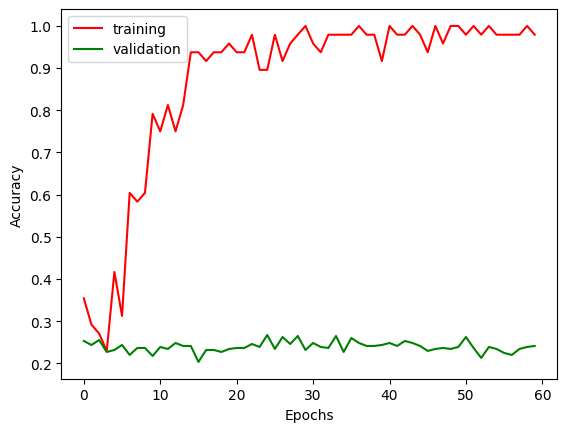

In [ ]:
make_figure(training_acc_LSTM, validation_acc_LSTM, name = "LSTM")

In [ ]:
###################################################################################
## Training and Test The CNN ##############################################################
###################################################################################
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 60, 64
data_cnn = {
    "x_train": x_train_CNN,
    "y_train": y_train_CNN,
    "x_valid": x_valid_CNN,
    "y_valid": y_valid_CNN
}
training_acc_CNN, validation_acc_CNN = train_model(data_cnn, optimizer, criterion, cnn, batch_size, num_epoch)
start_time = time.time()
test_model(cnn, model_choice="CNN", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  CNN(
  (model_nn): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.6, inplace=False)
    (10): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.399
[1, 52] loss: 1.376
[1, 78] loss: 1.348


  2%|▏         | 1/60 [00:01<01:34,  1.61s/it]

[1, 104] loss: 1.331
Validation Accuracy: 0.3333333432674408
Epoch:  2
[2, 26] loss: 1.307
[2, 52] loss: 1.270
[2, 78] loss: 1.231


  3%|▎         | 2/60 [00:03<01:31,  1.57s/it]

[2, 104] loss: 1.229
Validation Accuracy: 0.39007091522216797
Epoch:  3
[3, 26] loss: 1.209
[3, 52] loss: 1.193
[3, 78] loss: 1.177


  5%|▌         | 3/60 [00:04<01:29,  1.57s/it]

[3, 104] loss: 1.179
Validation Accuracy: 0.44680851697921753
Epoch:  4
[4, 26] loss: 1.159
[4, 52] loss: 1.158
[4, 78] loss: 1.141


  7%|▋         | 4/60 [00:06<01:27,  1.57s/it]

[4, 104] loss: 1.114
Validation Accuracy: 0.4869976341724396
Epoch:  5
[5, 26] loss: 1.124
[5, 52] loss: 1.134
[5, 78] loss: 1.126


  8%|▊         | 5/60 [00:07<01:26,  1.57s/it]

[5, 104] loss: 1.110
Validation Accuracy: 0.4964539110660553
Epoch:  6
[6, 26] loss: 1.091
[6, 52] loss: 1.102
[6, 78] loss: 1.091


 10%|█         | 6/60 [00:09<01:24,  1.56s/it]

[6, 104] loss: 1.099
Validation Accuracy: 0.5342789888381958
Epoch:  7
[7, 26] loss: 1.067
[7, 52] loss: 1.047
[7, 78] loss: 1.074


 12%|█▏        | 7/60 [00:10<01:22,  1.56s/it]

[7, 104] loss: 1.065
Validation Accuracy: 0.5815603137016296
Epoch:  8
[8, 26] loss: 1.019
[8, 52] loss: 1.048
[8, 78] loss: 1.028


 13%|█▎        | 8/60 [00:12<01:21,  1.57s/it]

[8, 104] loss: 1.031
Validation Accuracy: 0.5791962146759033
Epoch:  9
[9, 26] loss: 0.976
[9, 52] loss: 1.026
[9, 78] loss: 1.001


 15%|█▌        | 9/60 [00:14<01:19,  1.57s/it]

[9, 104] loss: 1.018
Validation Accuracy: 0.5768321752548218
Epoch:  10
[10, 26] loss: 0.947
[10, 52] loss: 0.974
[10, 78] loss: 0.963


 17%|█▋        | 10/60 [00:15<01:18,  1.57s/it]

[10, 104] loss: 0.967
Validation Accuracy: 0.6335697174072266
Epoch:  11
[11, 26] loss: 0.890
[11, 52] loss: 0.945
[11, 78] loss: 0.958


 18%|█▊        | 11/60 [00:17<01:16,  1.57s/it]

[11, 104] loss: 0.959
Validation Accuracy: 0.6382978558540344
Epoch:  12
[12, 26] loss: 0.933
[12, 52] loss: 0.934
[12, 78] loss: 0.925


 20%|██        | 12/60 [00:18<01:15,  1.57s/it]

[12, 104] loss: 0.935
Validation Accuracy: 0.6926714181900024
Epoch:  13
[13, 26] loss: 0.902
[13, 52] loss: 0.884
[13, 78] loss: 0.893


 22%|██▏       | 13/60 [00:20<01:13,  1.57s/it]

[13, 104] loss: 0.872
Validation Accuracy: 0.6784870028495789
Epoch:  14
[14, 26] loss: 0.857
[14, 52] loss: 0.888
[14, 78] loss: 0.893


 23%|██▎       | 14/60 [00:21<01:12,  1.57s/it]

[14, 104] loss: 0.861
Validation Accuracy: 0.6690307259559631
Epoch:  15
[15, 26] loss: 0.897
[15, 52] loss: 0.878
[15, 78] loss: 0.813


 25%|██▌       | 15/60 [00:23<01:10,  1.58s/it]

[15, 104] loss: 0.806
Validation Accuracy: 0.7210401892662048
Epoch:  16
[16, 26] loss: 0.789
[16, 52] loss: 0.877
[16, 78] loss: 0.874


 27%|██▋       | 16/60 [00:25<01:09,  1.58s/it]

[16, 104] loss: 0.836
Validation Accuracy: 0.6572104096412659
Epoch:  17
[17, 26] loss: 0.799
[17, 52] loss: 0.806
[17, 78] loss: 0.859


 28%|██▊       | 17/60 [00:26<01:08,  1.58s/it]

[17, 104] loss: 0.812
Validation Accuracy: 0.6666666865348816
Epoch:  18
[18, 26] loss: 0.799
[18, 52] loss: 0.799
[18, 78] loss: 0.806


 30%|███       | 18/60 [00:28<01:06,  1.58s/it]

[18, 104] loss: 0.810
Validation Accuracy: 0.6808510422706604
Epoch:  19
[19, 26] loss: 0.783
[19, 52] loss: 0.790
[19, 78] loss: 0.811


 32%|███▏      | 19/60 [00:29<01:05,  1.59s/it]

[19, 104] loss: 0.810
Validation Accuracy: 0.7186761498451233
Epoch:  20
[20, 26] loss: 0.794
[20, 52] loss: 0.751
[20, 78] loss: 0.786


 33%|███▎      | 20/60 [00:31<01:03,  1.59s/it]

[20, 104] loss: 0.797
Validation Accuracy: 0.7115839123725891
Epoch:  21
[21, 26] loss: 0.786
[21, 52] loss: 0.766
[21, 78] loss: 0.794


 35%|███▌      | 21/60 [00:33<01:02,  1.59s/it]

[21, 104] loss: 0.740
Validation Accuracy: 0.7234042286872864
Epoch:  22
[22, 26] loss: 0.744
[22, 52] loss: 0.739
[22, 78] loss: 0.788


 37%|███▋      | 22/60 [00:34<01:00,  1.59s/it]

[22, 104] loss: 0.779
Validation Accuracy: 0.7139480113983154
Epoch:  23
[23, 26] loss: 0.730
[23, 52] loss: 0.766
[23, 78] loss: 0.760


 38%|███▊      | 23/60 [00:36<00:58,  1.59s/it]

[23, 104] loss: 0.712
Validation Accuracy: 0.7092198729515076
Epoch:  24
[24, 26] loss: 0.745
[24, 52] loss: 0.726
[24, 78] loss: 0.749


 40%|████      | 24/60 [00:37<00:57,  1.59s/it]

[24, 104] loss: 0.748
Validation Accuracy: 0.6784870028495789
Epoch:  25
[25, 26] loss: 0.744
[25, 52] loss: 0.750
[25, 78] loss: 0.744


 42%|████▏     | 25/60 [00:39<00:55,  1.59s/it]

[25, 104] loss: 0.766
Validation Accuracy: 0.716312050819397
Epoch:  26
[26, 26] loss: 0.706
[26, 52] loss: 0.726
[26, 78] loss: 0.750


 43%|████▎     | 26/60 [00:41<00:54,  1.59s/it]

[26, 104] loss: 0.729
Validation Accuracy: 0.7115839123725891
Epoch:  27
[27, 26] loss: 0.719
[27, 52] loss: 0.676
[27, 78] loss: 0.749


 45%|████▌     | 27/60 [00:42<00:52,  1.59s/it]

[27, 104] loss: 0.716
Validation Accuracy: 0.7115839123725891
Epoch:  28
[28, 26] loss: 0.727
[28, 52] loss: 0.734
[28, 78] loss: 0.757


 47%|████▋     | 28/60 [00:44<00:50,  1.59s/it]

[28, 104] loss: 0.700
Validation Accuracy: 0.7139480113983154
Epoch:  29
[29, 26] loss: 0.692
[29, 52] loss: 0.721
[29, 78] loss: 0.710


 48%|████▊     | 29/60 [00:45<00:49,  1.59s/it]

[29, 104] loss: 0.736
Validation Accuracy: 0.7139480113983154
Epoch:  30
[30, 26] loss: 0.704
[30, 52] loss: 0.746
[30, 78] loss: 0.699


 50%|█████     | 30/60 [00:47<00:47,  1.59s/it]

[30, 104] loss: 0.711
Validation Accuracy: 0.6784870028495789
Epoch:  31
[31, 26] loss: 0.690
[31, 52] loss: 0.723
[31, 78] loss: 0.672


 52%|█████▏    | 31/60 [00:49<00:46,  1.59s/it]

[31, 104] loss: 0.719
Validation Accuracy: 0.695035457611084
Epoch:  32
[32, 26] loss: 0.687
[32, 52] loss: 0.703
[32, 78] loss: 0.689


 53%|█████▎    | 32/60 [00:50<00:44,  1.58s/it]

[32, 104] loss: 0.681
Validation Accuracy: 0.7044917345046997
Epoch:  33
[33, 26] loss: 0.698
[33, 52] loss: 0.711
[33, 78] loss: 0.707


 55%|█████▌    | 33/60 [00:52<00:42,  1.58s/it]

[33, 104] loss: 0.709
Validation Accuracy: 0.6808510422706604
Epoch:  34
[34, 26] loss: 0.710
[34, 52] loss: 0.681
[34, 78] loss: 0.718


 57%|█████▋    | 34/60 [00:53<00:40,  1.58s/it]

[34, 104] loss: 0.706
Validation Accuracy: 0.716312050819397
Epoch:  35
[35, 26] loss: 0.673
[35, 52] loss: 0.698
[35, 78] loss: 0.698


 58%|█████▊    | 35/60 [00:55<00:39,  1.58s/it]

[35, 104] loss: 0.642
Validation Accuracy: 0.7210401892662048
Epoch:  36
[36, 26] loss: 0.685
[36, 52] loss: 0.687
[36, 78] loss: 0.689


 60%|██████    | 36/60 [00:56<00:37,  1.58s/it]

[36, 104] loss: 0.687
Validation Accuracy: 0.7139480113983154
Epoch:  37
[37, 26] loss: 0.657
[37, 52] loss: 0.684
[37, 78] loss: 0.664


 62%|██████▏   | 37/60 [00:58<00:36,  1.58s/it]

[37, 104] loss: 0.658
Validation Accuracy: 0.6879432797431946
Epoch:  38
[38, 26] loss: 0.625
[38, 52] loss: 0.689
[38, 78] loss: 0.664


 63%|██████▎   | 38/60 [01:00<00:34,  1.58s/it]

[38, 104] loss: 0.693
Validation Accuracy: 0.7115839123725891
Epoch:  39
[39, 26] loss: 0.662
[39, 52] loss: 0.659
[39, 78] loss: 0.690


 65%|██████▌   | 39/60 [01:01<00:33,  1.57s/it]

[39, 104] loss: 0.641
Validation Accuracy: 0.7186761498451233
Epoch:  40
[40, 26] loss: 0.651
[40, 52] loss: 0.667
[40, 78] loss: 0.662


 67%|██████▋   | 40/60 [01:03<00:31,  1.57s/it]

[40, 104] loss: 0.643
Validation Accuracy: 0.7092198729515076
Epoch:  41
[41, 26] loss: 0.675
[41, 52] loss: 0.660
[41, 78] loss: 0.689


 68%|██████▊   | 41/60 [01:04<00:29,  1.57s/it]

[41, 104] loss: 0.652
Validation Accuracy: 0.7352246046066284
Epoch:  42
[42, 26] loss: 0.639
[42, 52] loss: 0.629
[42, 78] loss: 0.633


 70%|███████   | 42/60 [01:06<00:28,  1.57s/it]

[42, 104] loss: 0.670
Validation Accuracy: 0.7352246046066284
Epoch:  43
[43, 26] loss: 0.618
[43, 52] loss: 0.683
[43, 78] loss: 0.648


 72%|███████▏  | 43/60 [01:07<00:26,  1.57s/it]

[43, 104] loss: 0.647
Validation Accuracy: 0.7234042286872864
Epoch:  44
[44, 26] loss: 0.626
[44, 52] loss: 0.631
[44, 78] loss: 0.670


 73%|███████▎  | 44/60 [01:09<00:25,  1.57s/it]

[44, 104] loss: 0.639
Validation Accuracy: 0.7304964661598206
Epoch:  45
[45, 26] loss: 0.635
[45, 52] loss: 0.648
[45, 78] loss: 0.654


 75%|███████▌  | 45/60 [01:11<00:23,  1.57s/it]

[45, 104] loss: 0.647
Validation Accuracy: 0.7115839123725891
Epoch:  46
[46, 26] loss: 0.637
[46, 52] loss: 0.637
[46, 78] loss: 0.591


 77%|███████▋  | 46/60 [01:12<00:21,  1.57s/it]

[46, 104] loss: 0.662
Validation Accuracy: 0.7186761498451233
Epoch:  47
[47, 26] loss: 0.622
[47, 52] loss: 0.638
[47, 78] loss: 0.662


 78%|███████▊  | 47/60 [01:14<00:20,  1.57s/it]

[47, 104] loss: 0.641
Validation Accuracy: 0.7044917345046997
Epoch:  48
[48, 26] loss: 0.640
[48, 52] loss: 0.633
[48, 78] loss: 0.646


 80%|████████  | 48/60 [01:15<00:18,  1.57s/it]

[48, 104] loss: 0.674
Validation Accuracy: 0.7021276354789734
Epoch:  49
[49, 26] loss: 0.625
[49, 52] loss: 0.647
[49, 78] loss: 0.606


 82%|████████▏ | 49/60 [01:17<00:17,  1.56s/it]

[49, 104] loss: 0.643
Validation Accuracy: 0.6997635960578918
Epoch:  50
[50, 26] loss: 0.645
[50, 52] loss: 0.660
[50, 78] loss: 0.625


 83%|████████▎ | 50/60 [01:18<00:15,  1.56s/it]

[50, 104] loss: 0.633
Validation Accuracy: 0.7210401892662048
Epoch:  51
[51, 26] loss: 0.622
[51, 52] loss: 0.606
[51, 78] loss: 0.626


 85%|████████▌ | 51/60 [01:20<00:14,  1.56s/it]

[51, 104] loss: 0.637
Validation Accuracy: 0.7186761498451233
Epoch:  52
[52, 26] loss: 0.594
[52, 52] loss: 0.620
[52, 78] loss: 0.635


 87%|████████▋ | 52/60 [01:21<00:12,  1.56s/it]

[52, 104] loss: 0.650
Validation Accuracy: 0.6997635960578918
Epoch:  53
[53, 26] loss: 0.610
[53, 52] loss: 0.613
[53, 78] loss: 0.630


 88%|████████▊ | 53/60 [01:23<00:10,  1.56s/it]

[53, 104] loss: 0.679
Validation Accuracy: 0.6926714181900024
Epoch:  54
[54, 26] loss: 0.638
[54, 52] loss: 0.632
[54, 78] loss: 0.658


 90%|█████████ | 54/60 [01:25<00:09,  1.57s/it]

[54, 104] loss: 0.608
Validation Accuracy: 0.7281323671340942
Epoch:  55
[55, 26] loss: 0.573
[55, 52] loss: 0.630
[55, 78] loss: 0.626


 92%|█████████▏| 55/60 [01:26<00:07,  1.56s/it]

[55, 104] loss: 0.627
Validation Accuracy: 0.695035457611084
Epoch:  56
[56, 26] loss: 0.620
[56, 52] loss: 0.624
[56, 78] loss: 0.619


 93%|█████████▎| 56/60 [01:28<00:06,  1.56s/it]

[56, 104] loss: 0.653
Validation Accuracy: 0.7044917345046997
Epoch:  57
[57, 26] loss: 0.602
[57, 52] loss: 0.631
[57, 78] loss: 0.635


 95%|█████████▌| 57/60 [01:29<00:04,  1.56s/it]

[57, 104] loss: 0.609
Validation Accuracy: 0.6926714181900024
Epoch:  58
[58, 26] loss: 0.614
[58, 52] loss: 0.629
[58, 78] loss: 0.593


 97%|█████████▋| 58/60 [01:31<00:03,  1.56s/it]

[58, 104] loss: 0.602
Validation Accuracy: 0.7092198729515076
Epoch:  59
[59, 26] loss: 0.599
[59, 52] loss: 0.603
[59, 78] loss: 0.625


 98%|█████████▊| 59/60 [01:32<00:01,  1.56s/it]

[59, 104] loss: 0.590
Validation Accuracy: 0.6926714181900024
Epoch:  60
[60, 26] loss: 0.606
[60, 52] loss: 0.622
[60, 78] loss: 0.594


100%|██████████| 60/60 [01:34<00:00,  1.57s/it]

[60, 104] loss: 0.607
Validation Accuracy: 0.7092198729515076
Finish Training


Test accuracy for  CNN is:  0.6862302483069977
Time To Run:  0.30758047103881836 seconds


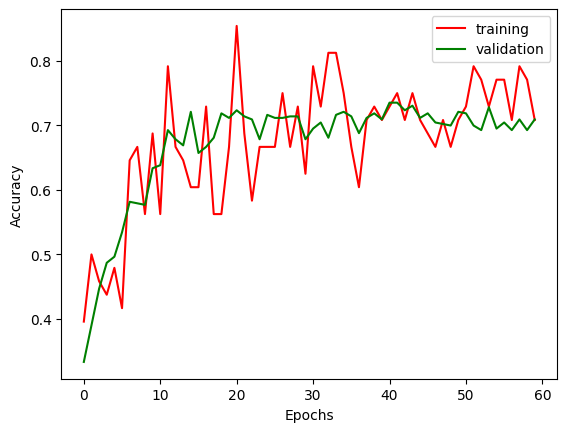

In [ ]:
make_figure(training_acc_CNN, validation_acc_CNN, name = "CNN")

In [ ]:
###################################################################################
## Training and Test The CNN + LSTM ###############################################
###################################################################################
cnn_lstm = CLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_lstm.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 60, 64
data_cnn = {
    "x_train": x_train_CNN,
    "y_train": y_train_CNN,
    "x_valid": x_valid_CNN,
    "y_valid": y_valid_CNN
}
training_acc_CLSTM, validation_acc_CLSTM = train_model(data_cnn, optimizer, criterion, cnn_lstm, batch_size, num_epoch)
start_time = time.time()
test_model(cnn_lstm, model_choice="CLSTM", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  CLSTM(
  (model): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.6, inplace=False)
    (10): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.386
[1, 52] loss: 1.386
[1, 78] loss: 1.378


  2%|▏         | 1/60 [00:02<02:31,  2.57s/it]

[1, 104] loss: 1.365
Validation Accuracy: 0.2884160876274109
Epoch:  2
[2, 26] loss: 1.339
[2, 52] loss: 1.313
[2, 78] loss: 1.270


  3%|▎         | 2/60 [00:04<02:07,  2.21s/it]

[2, 104] loss: 1.250
Validation Accuracy: 0.4160756468772888
Epoch:  3
[3, 26] loss: 1.233
[3, 52] loss: 1.206
[3, 78] loss: 1.207


  5%|▌         | 3/60 [00:06<01:58,  2.08s/it]

[3, 104] loss: 1.196
Validation Accuracy: 0.43971630930900574
Epoch:  4
[4, 26] loss: 1.181
[4, 52] loss: 1.203
[4, 78] loss: 1.182


  7%|▋         | 4/60 [00:08<01:53,  2.03s/it]

[4, 104] loss: 1.165
Validation Accuracy: 0.38770684599876404
Epoch:  5
[5, 26] loss: 1.152
[5, 52] loss: 1.138
[5, 78] loss: 1.155


  8%|▊         | 5/60 [00:10<01:49,  2.00s/it]

[5, 104] loss: 1.135
Validation Accuracy: 0.4373522400856018
Epoch:  6
[6, 26] loss: 1.114
[6, 52] loss: 1.121
[6, 78] loss: 1.128


 10%|█         | 6/60 [00:12<01:46,  1.98s/it]

[6, 104] loss: 1.138
Validation Accuracy: 0.4208037853240967
Epoch:  7
[7, 26] loss: 1.108
[7, 52] loss: 1.084
[7, 78] loss: 1.098


 12%|█▏        | 7/60 [00:14<01:45,  1.99s/it]

[7, 104] loss: 1.123
Validation Accuracy: 0.4137115776538849
Epoch:  8
[8, 26] loss: 1.065
[8, 52] loss: 1.107
[8, 78] loss: 1.108


 13%|█▎        | 8/60 [00:16<01:42,  1.98s/it]

[8, 104] loss: 1.060
Validation Accuracy: 0.45390069484710693
Epoch:  9
[9, 26] loss: 1.053
[9, 52] loss: 1.094
[9, 78] loss: 1.070


 15%|█▌        | 9/60 [00:18<01:41,  1.98s/it]

[9, 104] loss: 1.108
Validation Accuracy: 0.4609929025173187
Epoch:  10
[10, 26] loss: 1.063
[10, 52] loss: 1.056
[10, 78] loss: 1.061


 17%|█▋        | 10/60 [00:20<01:38,  1.97s/it]

[10, 104] loss: 1.057
Validation Accuracy: 0.4964539110660553
Epoch:  11
[11, 26] loss: 0.994
[11, 52] loss: 1.046
[11, 78] loss: 1.071


 18%|█▊        | 11/60 [00:22<01:36,  1.97s/it]

[11, 104] loss: 1.064
Validation Accuracy: 0.49881798028945923
Epoch:  12
[12, 26] loss: 1.029
[12, 52] loss: 1.041
[12, 78] loss: 1.064


 20%|██        | 12/60 [00:24<01:34,  1.97s/it]

[12, 104] loss: 1.019
Validation Accuracy: 0.5059101581573486
Epoch:  13
[13, 26] loss: 1.023
[13, 52] loss: 1.020
[13, 78] loss: 1.003


 22%|██▏       | 13/60 [00:26<01:32,  1.97s/it]

[13, 104] loss: 1.009
Validation Accuracy: 0.48463356494903564
Epoch:  14
[14, 26] loss: 1.016
[14, 52] loss: 1.006
[14, 78] loss: 0.984


 23%|██▎       | 14/60 [00:28<01:31,  1.98s/it]

[14, 104] loss: 0.978
Validation Accuracy: 0.49172577261924744
Epoch:  15
[15, 26] loss: 1.041
[15, 52] loss: 1.002
[15, 78] loss: 0.984


 25%|██▌       | 15/60 [00:30<01:29,  1.99s/it]

[15, 104] loss: 0.969
Validation Accuracy: 0.5484633445739746
Epoch:  16
[16, 26] loss: 0.940
[16, 52] loss: 0.988
[16, 78] loss: 0.976


 27%|██▋       | 16/60 [00:32<01:27,  1.99s/it]

[16, 104] loss: 0.985
Validation Accuracy: 0.5153664350509644
Epoch:  17
[17, 26] loss: 0.956
[17, 52] loss: 0.958
[17, 78] loss: 0.972


 28%|██▊       | 17/60 [00:34<01:25,  1.99s/it]

[17, 104] loss: 0.956
Validation Accuracy: 0.49408984184265137
Epoch:  18
[18, 26] loss: 0.955
[18, 52] loss: 0.941
[18, 78] loss: 0.933


 30%|███       | 18/60 [00:36<01:23,  1.98s/it]

[18, 104] loss: 0.987
Validation Accuracy: 0.5839243531227112
Epoch:  19
[19, 26] loss: 0.927
[19, 52] loss: 0.937
[19, 78] loss: 0.941


 32%|███▏      | 19/60 [00:38<01:21,  1.99s/it]

[19, 104] loss: 0.949
Validation Accuracy: 0.5768321752548218
Epoch:  20
[20, 26] loss: 0.899
[20, 52] loss: 0.899
[20, 78] loss: 0.895


 33%|███▎      | 20/60 [00:40<01:19,  1.99s/it]

[20, 104] loss: 0.946
Validation Accuracy: 0.5697399377822876
Epoch:  21
[21, 26] loss: 0.933
[21, 52] loss: 0.931
[21, 78] loss: 0.930


 35%|███▌      | 21/60 [00:42<01:17,  2.00s/it]

[21, 104] loss: 0.887
Validation Accuracy: 0.5721040368080139
Epoch:  22
[22, 26] loss: 0.916
[22, 52] loss: 0.891
[22, 78] loss: 0.919


 37%|███▋      | 22/60 [00:44<01:15,  1.99s/it]

[22, 104] loss: 0.897
Validation Accuracy: 0.5697399377822876
Epoch:  23
[23, 26] loss: 0.884
[23, 52] loss: 0.888
[23, 78] loss: 0.890


 38%|███▊      | 23/60 [00:46<01:13,  1.99s/it]

[23, 104] loss: 0.894
Validation Accuracy: 0.5626477599143982
Epoch:  24
[24, 26] loss: 0.871
[24, 52] loss: 0.850
[24, 78] loss: 0.861


 40%|████      | 24/60 [00:47<01:11,  1.98s/it]

[24, 104] loss: 0.873
Validation Accuracy: 0.5768321752548218
Epoch:  25
[25, 26] loss: 0.873
[25, 52] loss: 0.834
[25, 78] loss: 0.874


 42%|████▏     | 25/60 [00:49<01:09,  1.98s/it]

[25, 104] loss: 0.834
Validation Accuracy: 0.609929084777832
Epoch:  26
[26, 26] loss: 0.834
[26, 52] loss: 0.838
[26, 78] loss: 0.855


 43%|████▎     | 26/60 [00:51<01:07,  1.98s/it]

[26, 104] loss: 0.855
Validation Accuracy: 0.6359338164329529
Epoch:  27
[27, 26] loss: 0.842
[27, 52] loss: 0.804
[27, 78] loss: 0.818


 45%|████▌     | 27/60 [00:53<01:05,  1.98s/it]

[27, 104] loss: 0.818
Validation Accuracy: 0.631205677986145
Epoch:  28
[28, 26] loss: 0.811
[28, 52] loss: 0.813
[28, 78] loss: 0.808


 47%|████▋     | 28/60 [00:55<01:03,  1.98s/it]

[28, 104] loss: 0.791
Validation Accuracy: 0.6548463106155396
Epoch:  29
[29, 26] loss: 0.785
[29, 52] loss: 0.809
[29, 78] loss: 0.795


 48%|████▊     | 29/60 [00:57<01:01,  1.97s/it]

[29, 104] loss: 0.805
Validation Accuracy: 0.6028369069099426
Epoch:  30
[30, 26] loss: 0.778
[30, 52] loss: 0.827
[30, 78] loss: 0.736


 50%|█████     | 30/60 [00:59<00:59,  1.97s/it]

[30, 104] loss: 0.777
Validation Accuracy: 0.652482271194458
Epoch:  31
[31, 26] loss: 0.794
[31, 52] loss: 0.770
[31, 78] loss: 0.742


 52%|█████▏    | 31/60 [01:01<00:57,  1.97s/it]

[31, 104] loss: 0.823
Validation Accuracy: 0.6453900933265686
Epoch:  32
[32, 26] loss: 0.780
[32, 52] loss: 0.757
[32, 78] loss: 0.779


 53%|█████▎    | 32/60 [01:03<00:55,  1.97s/it]

[32, 104] loss: 0.783
Validation Accuracy: 0.6406619548797607
Epoch:  33
[33, 26] loss: 0.762
[33, 52] loss: 0.783
[33, 78] loss: 0.751


 55%|█████▌    | 33/60 [01:05<00:53,  1.96s/it]

[33, 104] loss: 0.779
Validation Accuracy: 0.6430259943008423
Epoch:  34
[34, 26] loss: 0.744
[34, 52] loss: 0.771
[34, 78] loss: 0.780


 57%|█████▋    | 34/60 [01:07<00:51,  1.97s/it]

[34, 104] loss: 0.748
Validation Accuracy: 0.6406619548797607
Epoch:  35
[35, 26] loss: 0.799
[35, 52] loss: 0.745
[35, 78] loss: 0.722


 58%|█████▊    | 35/60 [01:09<00:49,  1.97s/it]

[35, 104] loss: 0.741
Validation Accuracy: 0.6784870028495789
Epoch:  36
[36, 26] loss: 0.729
[36, 52] loss: 0.715
[36, 78] loss: 0.748


 60%|██████    | 36/60 [01:11<00:47,  1.96s/it]

[36, 104] loss: 0.738
Validation Accuracy: 0.6784870028495789
Epoch:  37
[37, 26] loss: 0.743
[37, 52] loss: 0.733
[37, 78] loss: 0.720


 62%|██████▏   | 37/60 [01:13<00:45,  1.97s/it]

[37, 104] loss: 0.741
Validation Accuracy: 0.6690307259559631
Epoch:  38
[38, 26] loss: 0.698
[38, 52] loss: 0.733
[38, 78] loss: 0.688


 63%|██████▎   | 38/60 [01:15<00:43,  1.97s/it]

[38, 104] loss: 0.757
Validation Accuracy: 0.695035457611084
Epoch:  39
[39, 26] loss: 0.720
[39, 52] loss: 0.709
[39, 78] loss: 0.725


 65%|██████▌   | 39/60 [01:17<00:41,  1.96s/it]

[39, 104] loss: 0.714
Validation Accuracy: 0.631205677986145
Epoch:  40
[40, 26] loss: 0.703
[40, 52] loss: 0.729
[40, 78] loss: 0.685


 67%|██████▋   | 40/60 [01:19<00:39,  1.96s/it]

[40, 104] loss: 0.703
Validation Accuracy: 0.6761229038238525
Epoch:  41
[41, 26] loss: 0.670
[41, 52] loss: 0.713
[41, 78] loss: 0.688


 68%|██████▊   | 41/60 [01:21<00:37,  1.96s/it]

[41, 104] loss: 0.754
Validation Accuracy: 0.6879432797431946
Epoch:  42
[42, 26] loss: 0.684
[42, 52] loss: 0.690
[42, 78] loss: 0.710


 70%|███████   | 42/60 [01:23<00:35,  1.96s/it]

[42, 104] loss: 0.701
Validation Accuracy: 0.6808510422706604
Epoch:  43
[43, 26] loss: 0.651
[43, 52] loss: 0.719
[43, 78] loss: 0.687


 72%|███████▏  | 43/60 [01:25<00:33,  1.96s/it]

[43, 104] loss: 0.684
Validation Accuracy: 0.6713948249816895
Epoch:  44
[44, 26] loss: 0.677
[44, 52] loss: 0.687
[44, 78] loss: 0.704


 73%|███████▎  | 44/60 [01:27<00:31,  1.95s/it]

[44, 104] loss: 0.702
Validation Accuracy: 0.6713948249816895
Epoch:  45
[45, 26] loss: 0.680
[45, 52] loss: 0.692
[45, 78] loss: 0.681


 75%|███████▌  | 45/60 [01:29<00:29,  1.95s/it]

[45, 104] loss: 0.667
Validation Accuracy: 0.6761229038238525
Epoch:  46
[46, 26] loss: 0.662
[46, 52] loss: 0.698
[46, 78] loss: 0.661


 77%|███████▋  | 46/60 [01:31<00:27,  1.95s/it]

[46, 104] loss: 0.715
Validation Accuracy: 0.6643025875091553
Epoch:  47
[47, 26] loss: 0.662
[47, 52] loss: 0.644
[47, 78] loss: 0.698


 78%|███████▊  | 47/60 [01:33<00:25,  1.95s/it]

[47, 104] loss: 0.680
Validation Accuracy: 0.6643025875091553
Epoch:  48
[48, 26] loss: 0.632
[48, 52] loss: 0.713
[48, 78] loss: 0.675


 80%|████████  | 48/60 [01:35<00:23,  1.96s/it]

[48, 104] loss: 0.679
Validation Accuracy: 0.6643025875091553
Epoch:  49
[49, 26] loss: 0.644
[49, 52] loss: 0.684
[49, 78] loss: 0.621


 82%|████████▏ | 49/60 [01:37<00:21,  1.95s/it]

[49, 104] loss: 0.684
Validation Accuracy: 0.6879432797431946
Epoch:  50
[50, 26] loss: 0.687
[50, 52] loss: 0.675
[50, 78] loss: 0.654


 83%|████████▎ | 50/60 [01:38<00:19,  1.95s/it]

[50, 104] loss: 0.664
Validation Accuracy: 0.6453900933265686
Epoch:  51
[51, 26] loss: 0.653
[51, 52] loss: 0.658
[51, 78] loss: 0.648


 85%|████████▌ | 51/60 [01:40<00:17,  1.95s/it]

[51, 104] loss: 0.661
Validation Accuracy: 0.6808510422706604
Epoch:  52
[52, 26] loss: 0.657
[52, 52] loss: 0.668
[52, 78] loss: 0.655


 87%|████████▋ | 52/60 [01:42<00:15,  1.95s/it]

[52, 104] loss: 0.677
Validation Accuracy: 0.6690307259559631
Epoch:  53
[53, 26] loss: 0.614
[53, 52] loss: 0.647
[53, 78] loss: 0.650


 88%|████████▊ | 53/60 [01:44<00:13,  1.95s/it]

[53, 104] loss: 0.657
Validation Accuracy: 0.6761229038238525
Epoch:  54
[54, 26] loss: 0.601
[54, 52] loss: 0.620
[54, 78] loss: 0.665


 90%|█████████ | 54/60 [01:46<00:11,  1.96s/it]

[54, 104] loss: 0.597
Validation Accuracy: 0.6879432797431946
Epoch:  55
[55, 26] loss: 0.653
[55, 52] loss: 0.620
[55, 78] loss: 0.651


 92%|█████████▏| 55/60 [01:48<00:09,  1.96s/it]

[55, 104] loss: 0.616
Validation Accuracy: 0.6855791807174683
Epoch:  56
[56, 26] loss: 0.615
[56, 52] loss: 0.636
[56, 78] loss: 0.640


 93%|█████████▎| 56/60 [01:50<00:07,  1.96s/it]

[56, 104] loss: 0.651
Validation Accuracy: 0.7044917345046997
Epoch:  57
[57, 26] loss: 0.662
[57, 52] loss: 0.643
[57, 78] loss: 0.568


 95%|█████████▌| 57/60 [01:52<00:05,  1.96s/it]

[57, 104] loss: 0.653
Validation Accuracy: 0.6903073191642761
Epoch:  58
[58, 26] loss: 0.626
[58, 52] loss: 0.678
[58, 78] loss: 0.607


 97%|█████████▋| 58/60 [01:54<00:03,  1.96s/it]

[58, 104] loss: 0.627
Validation Accuracy: 0.6855791807174683
Epoch:  59
[59, 26] loss: 0.596
[59, 52] loss: 0.580
[59, 78] loss: 0.598


 98%|█████████▊| 59/60 [01:56<00:01,  1.96s/it]

[59, 104] loss: 0.629
Validation Accuracy: 0.6926714181900024
Epoch:  60
[60, 26] loss: 0.578
[60, 52] loss: 0.604
[60, 78] loss: 0.636


100%|██████████| 60/60 [01:58<00:00,  1.98s/it]

[60, 104] loss: 0.641
Validation Accuracy: 0.6903073191642761
Finish Training


Test accuracy for  CLSTM is:  0.6501128668171557
Time To Run:  0.29947519302368164 seconds


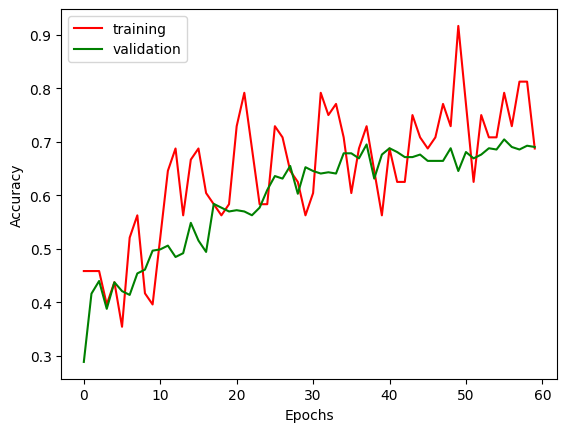

In [ ]:
make_figure(training_acc_CLSTM, validation_acc_CLSTM, name = "CLSTM")